***Training and Saving the Logistic Regression Model***

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import joblib

file_path = r"C:\Users\rajan\Downloads\data_public.csv.gz"
data = pd.read_csv(file_path, compression='gzip').sample(frac=0.2, random_state=42)

X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='passthrough')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))])

param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['lbfgs', 'liblinear'],
}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

joblib.dump(grid_search.best_estimator_, 'final_model_lr.pkl')

y_pred = grid_search.predict(X_test)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test), multi_class='ovr')

print('Classification Report:', report)
print('ROC-AUC Score:', roc_auc)

Classification Report:               precision    recall  f1-score   support

           1       0.51      0.29      0.37      7171
           2       0.75      1.00      0.86     18112
           3       0.74      0.64      0.69     22717

    accuracy                           0.73     48000
   macro avg       0.67      0.65      0.64     48000
weighted avg       0.71      0.73      0.70     48000

ROC-AUC Score: 0.8393729651198453


***Converting the Model to ONNX***

In [4]:
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

model = joblib.load('final_model_lr.pkl')

all_feature_names = X_train.columns.tolist()

initial_types = [(name, FloatTensorType([None, 1])) for name in all_feature_names]

onnx_model = convert_sklearn(model, initial_types=initial_types)
with open("final_model_lr.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX model saved as final_model_lr.onnx")

ONNX model saved as final_model_lr.onnx


***Testing the ONNX Model***

In [6]:
import onnxruntime as rt
import numpy as np
import pandas as pd

onnx_model_path_lr = 'final_model_lr.onnx'
sess_lr = rt.InferenceSession(onnx_model_path_lr)

file_path = r"C:\Users\rajan\Downloads\data_public.csv.gz"
data = pd.read_csv(file_path, compression='gzip')
X_sample = data.drop('Class', axis=1).head(1)

preprocessor = model.named_steps['preprocessor']
X_sample_processed = preprocessor.transform(X_sample)

input_names = [input.name for input in sess_lr.get_inputs()]

input_feed = {name: X_sample_processed[:, idx].reshape(-1, 1).astype(np.float32) for idx, name in enumerate(input_names)}

pred_onnx_lr = sess_lr.run(None, input_feed)[0]
print("ONNX model prediction (Logistic Regression):", pred_onnx_lr)

ONNX model prediction (Logistic Regression): [3]


***Testing with Additional Verifications***

In [8]:
import onnxruntime as rt
import numpy as np

onnx_model_path = 'final_model_lr.onnx'
sess = rt.InferenceSession(onnx_model_path)

X_sample = X_test.head(5)
X_sample_processed = model.named_steps['preprocessor'].transform(X_sample)

input_names = [input.name for input in sess.get_inputs()]
input_feed = {name: X_sample_processed[:, i].reshape(-1, 1).astype(np.float32) for i, name in enumerate(input_names)}

onnx_output = sess.run(None, input_feed)
pred_onnx_lr = onnx_output[0]
proba_onnx_lr = onnx_output[1]

print("ONNX model predictions (Logistic Regression):", pred_onnx_lr)
print("ONNX model probabilities (Logistic Regression):", proba_onnx_lr)

y_proba_original = model.predict_proba(X_sample)
y_pred_original = model.predict(X_sample)

print("Original model predictions:", y_pred_original)
print("Original model probabilities:", y_proba_original)

def convert_onnx_output(output):
    if isinstance(output, list):
        if isinstance(output[0], dict):
            return np.array([list(item.values()) for item in output], dtype=np.float32)
        else:
            return np.array(output, dtype=np.float32)
    return output.astype(np.float32)

proba_onnx_lr = convert_onnx_output(proba_onnx_lr)

y_proba_original = y_proba_original.astype(np.float32)

print("ONNX model predictions:", pred_onnx_lr)
print("Original model predictions:", y_pred_original)
if not np.array_equal(pred_onnx_lr, y_pred_original):
    print("Predictions do not match:")
    print("ONNX model predictions:", pred_onnx_lr)
    print("Original model predictions:", y_pred_original)
else:
    print("Predictions match between the original and ONNX models")

print("ONNX model probabilities:", proba_onnx_lr)
print("Original model probabilities:", y_proba_original)
if not np.allclose(proba_onnx_lr, y_proba_original, atol=1e-6):
    print("Probabilities do not match:")
    print("ONNX model probabilities:", proba_onnx_lr)
    print("Original model probabilities:", y_proba_original)
else:
    print("Probabilities match between the original and ONNX models")

ONNX model predictions (Logistic Regression): [3 2 3 2 3]
ONNX model probabilities (Logistic Regression): [{1: 0.0032461152877658606, 2: 0.4708440601825714, 3: 0.5259098410606384}, {1: 0.002784894546493888, 2: 0.5093256831169128, 3: 0.48788946866989136}, {1: 0.00320818810723722, 2: 0.4719271659851074, 3: 0.5248646140098572}, {1: 0.0027841925621032715, 2: 0.5093762874603271, 3: 0.48783954977989197}, {1: 0.0034528544638305902, 2: 0.46899062395095825, 3: 0.5275564789772034}]
Original model predictions: [3 2 3 2 1]
Original model probabilities: [[2.06670905e-01 9.39886532e-05 7.93235107e-01]
 [7.22683153e-04 7.24255785e-01 2.75021532e-01]
 [1.66955161e-01 1.23816080e-04 8.32921022e-01]
 [7.73190684e-04 7.18775920e-01 2.80450890e-01]
 [5.85548276e-01 3.42028480e-04 4.14109696e-01]]
ONNX model predictions: [3 2 3 2 3]
Original model predictions: [3 2 3 2 1]
Predictions do not match:
ONNX model predictions: [3 2 3 2 3]
Original model predictions: [3 2 3 2 1]
ONNX model probabilities: [[0.0032

In [9]:
import onnxruntime as rt
import numpy as np
import pandas as pd

onnx_model_path_lr = r"C:\Users\rajan\Downloads\final_model_lr.onnx"
sess_lr = rt.InferenceSession(onnx_model_path_lr)

file_path = r"C:\Users\rajan\Downloads\data_public.csv.gz"
data = pd.read_csv(file_path, compression='gzip')
X_sample = data.drop('Class', axis=1).head(1)

X_sample_processed = {col: X_sample[col].values.astype(np.float32).reshape(-1, 1) for col in X_sample.columns}

input_names = [input.name for input in sess_lr.get_inputs()]

input_feed = {name: X_sample_processed[name] for name in input_names}

onnx_output = sess_lr.run(None, input_feed)
pred_onnx_lr = onnx_output[0]
proba_onnx_lr = onnx_output[1]

print("ONNX model predictions:", pred_onnx_lr)
print("ONNX model probabilities:", proba_onnx_lr)

ONNX model predictions: [3]
ONNX model probabilities: [{1: 0.24430817365646362, 2: 5.686017175321467e-05, 3: 0.7556349635124207}]


In [10]:
import numpy as np
import pandas as pd
import onnxruntime as rt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

model = joblib.load('final_model_lr.pkl')

onnx_model_path_lr = 'final_model_lr.onnx'
sess_lr = rt.InferenceSession(onnx_model_path_lr)

file_path = r"C:\Users\rajan\Downloads\data_public.csv.gz"
data = pd.read_csv(file_path, compression='gzip')
X_sample = data.drop('Class', axis=1).head(1)
y_sample = data['Class'].head(1)

X_sample_processed = {col: X_sample[col].values.astype(np.float32).reshape(-1, 1) for col in X_sample.columns}

input_names = [input.name for input in sess_lr.get_inputs()]

input_feed = {name: X_sample_processed[name] for name in input_names}

onnx_output = sess_lr.run(None, input_feed)
pred_onnx_lr = onnx_output[0]
proba_onnx_lr = onnx_output[1]

y_pred_original = model.predict(X_sample)
y_proba_original = model.predict_proba(X_sample)

proba_onnx_lr_array = np.array([list(prob.values()) for prob in proba_onnx_lr])

print("ONNX model predictions:", pred_onnx_lr)
print("ONNX model probabilities:", proba_onnx_lr)
print("Original model predictions:", y_pred_original)
print("Original model probabilities:", y_proba_original)

proba_onnx_lr_array = proba_onnx_lr_array.astype(np.float32)
y_proba_original = y_proba_original.astype(np.float32)

print("ONNX model probabilities (array):", proba_onnx_lr_array)
print("Original model probabilities (array):", y_proba_original)

for i in range(proba_onnx_lr_array.shape[0]):
    print(f"Sample {i+1}:")
    for j in range(proba_onnx_lr_array.shape[1]):
        print(f"Class {j+1} - ONNX: {proba_onnx_lr_array[i, j]}, Original: {y_proba_original[i, j]}, Difference: {proba_onnx_lr_array[i, j] - y_proba_original[i, j]}")
    print()

absolute_differences = np.abs(proba_onnx_lr_array - y_proba_original)
print("Absolute differences between ONNX and original model probabilities:", absolute_differences)

assert np.array_equal(pred_onnx_lr, y_pred_original), "Predictions do not match"
print("Predictions match between the original and ONNX models")

if not np.allclose(proba_onnx_lr_array, y_proba_original, atol=1e-2):
    print("Probabilities do not match within the higher tolerance level.")
else:
    print("Probabilities match between the original and ONNX models within the higher tolerance level.")

ONNX model predictions: [3]
ONNX model probabilities: [{1: 0.24430817365646362, 2: 5.686017175321467e-05, 3: 0.7556349635124207}]
Original model predictions: [3]
Original model probabilities: [[2.44308122e-01 5.68601619e-05 7.55635017e-01]]
ONNX model probabilities (array): [[2.4430817e-01 5.6860172e-05 7.5563496e-01]]
Original model probabilities (array): [[2.4430813e-01 5.6860161e-05 7.5563502e-01]]
Sample 1:
Class 1 - ONNX: 0.24430817365646362, Original: 0.24430812895298004, Difference: 4.470348358154297e-08
Class 2 - ONNX: 5.686017175321467e-05, Original: 5.686016083927825e-05, Difference: 1.0913936421275139e-11
Class 3 - ONNX: 0.7556349635124207, Original: 0.7556350231170654, Difference: -5.960464477539063e-08

Absolute differences between ONNX and original model probabilities: [[4.4703484e-08 1.0913936e-11 5.9604645e-08]]
Predictions match between the original and ONNX models
Probabilities match between the original and ONNX models within the higher tolerance level.


***Data Visualization***

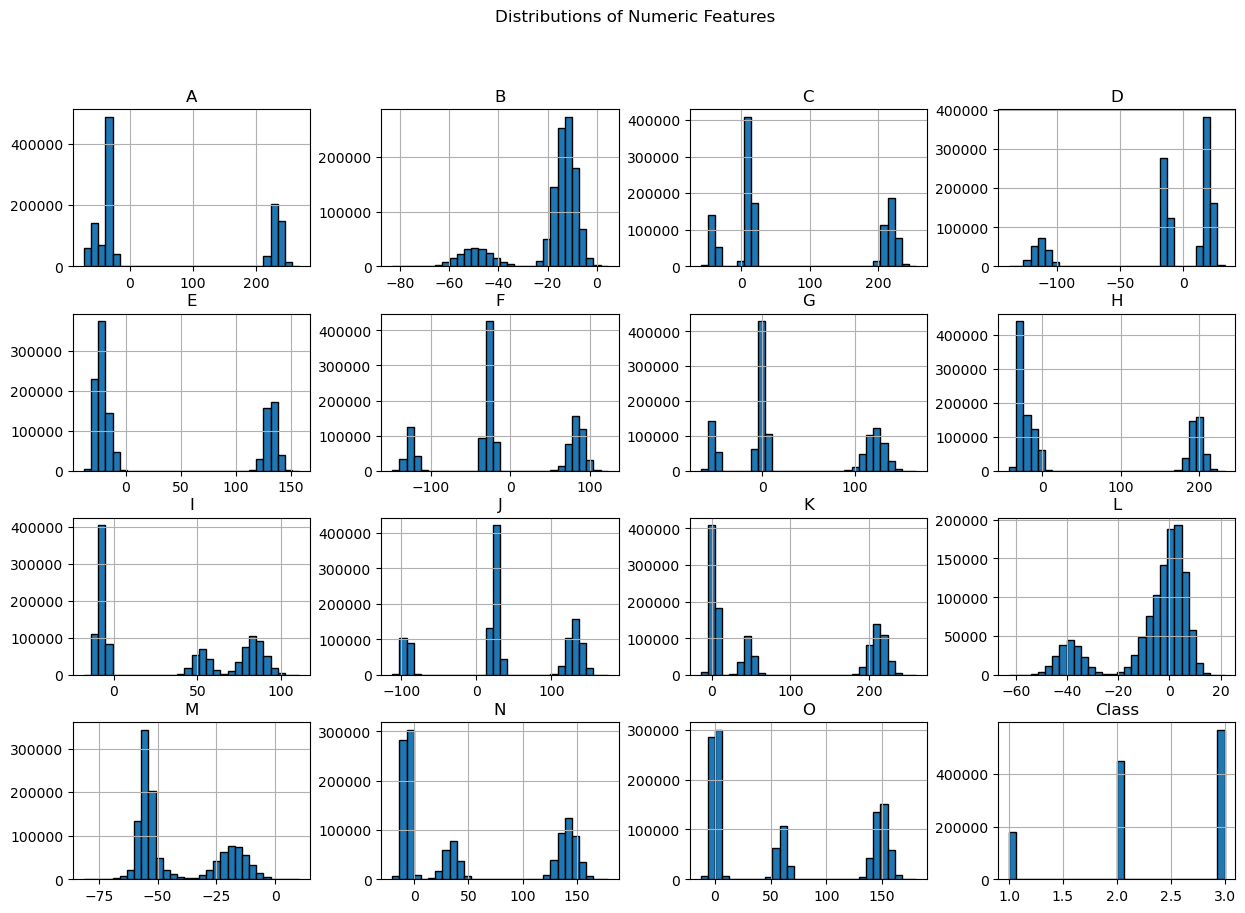

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\rajan\Downloads\data_public.csv.gz"
data = pd.read_csv(file_path, compression='gzip')

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_features].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

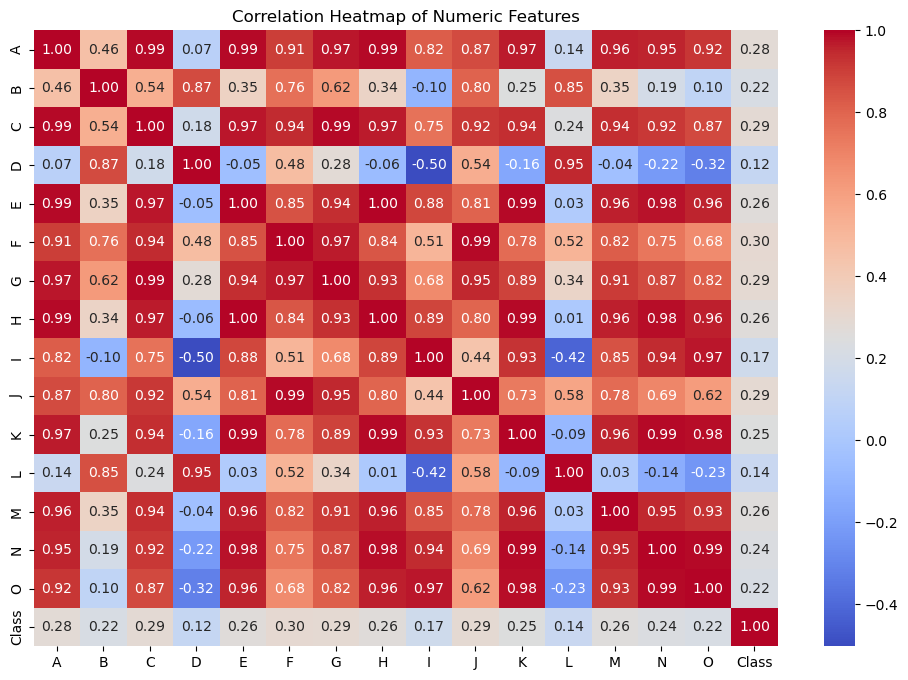

In [13]:
plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

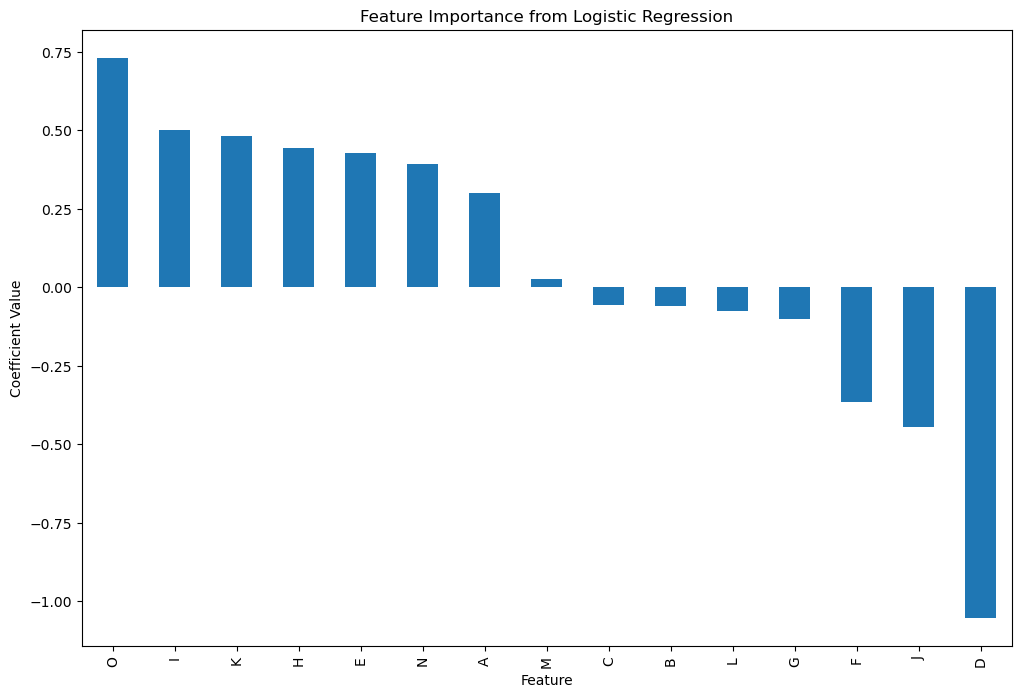

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = data.drop('Class', axis=1)
y = data['Class']
X_train = StandardScaler().fit_transform(X)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 8))
plt.title('Feature Importance from Logistic Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.show()

C:\Users\rajan\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


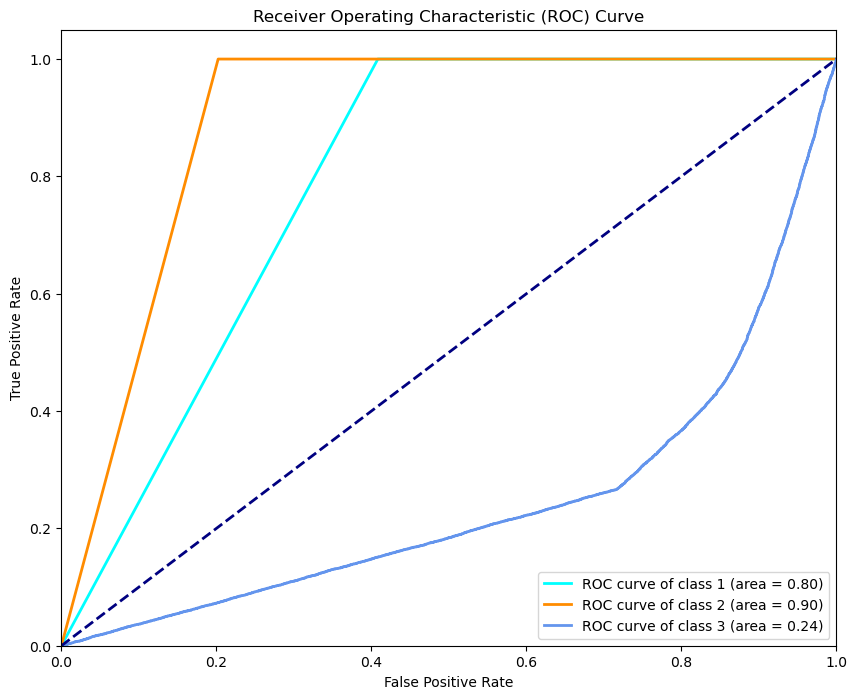

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

y_proba = log_reg.predict_proba(X_test)

y_test_binarized = label_binarize(y_test, classes=log_reg.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(log_reg.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(log_reg.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {log_reg.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

C:\Users\rajan\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


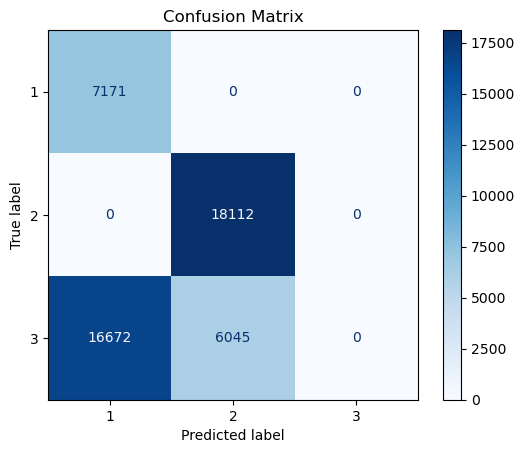

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()